In [2]:
import requests, os
from zipfile import ZipFile

# @title Loading Animal Faces Randomized data

print("Start downloading and unzipping `Randomized AnimalFaces` dataset...")

names = ['afhq_random_32x32', 'afhq_10_32x32']
urls = ["https://osf.io/9sj7p/download",
        "https://osf.io/wvgkq/download"]


for i, name in enumerate(names):
  url = urls[i]
  fname = f"{name}.zip"

  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)

    if os.path.exists(fname):
      with ZipFile(fname, 'r') as zfile:
        zfile.extractall(f".")
        os.remove(fname)

print("Download completed.")

Start downloading and unzipping `Randomized AnimalFaces` dataset...


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'afhq_10_32x32.zip'

In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:
import time
import copy
import torch
import pathlib
from pathlib import Path


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.auto import tqdm
from IPython.display import HTML

from utils import *


In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [75]:
class AnimalNet(nn.Module):
    """
    Network Class - Animal Faces
    """

    def __init__(self):
        """
        Initialize parameters of AnimalNet

        Args:
            None
        
        Returns:
            Nothing
        """
        super(AnimalNet, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128) # 3 colors, 32x32 pixels images
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32,3)
        # Why not use nn.Sequential here? you can. See below


    def forward(self,x):
        # make x a vector
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [78]:
# is this equivalent? Yes. I get the same result

class AnimalNet(nn.Module):
    """
    Network Class - Animal Faces
    """

    def __init__(self):
        """
        Initialize parameters of AnimalNet

        Args:
            None
        
        Returns:
            Nothing
        """
        super(AnimalNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3*32*32, 128), # 3 colors, 32x32 pixels images
            nn.ReLU(), # alternatively, nn.ReLU()
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,3)
        )

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        output = F.log_softmax(x, dim=1) # this could maybe be put into self.layers above, no?
        return output

    

#### Train and Test Functions

In [12]:
def train(args, model, train_loader, optimizer, reg_function1=None, reg_function2=None, criterion=nn.CrossEntropyLoss()):
    """
    Trains the current input model using the data
    from Train_loader and Updates parameters for a single pass

    Args:
        args: dictionary
        Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
        model: nn.module
        Neural network instance
        train_loader: torch.loader
        Input dataset
        optimizer: function
        Optimizer
        reg_function1: function
        Regularisation function [default: None]
        reg_function2: function
        Regularisation function [default: None]
        criterion: function
        Specifies loss function [default: nll_loss]

    Returns:
        model: nn.module
        Neural network instance post training
    """
    device = args['device']
    model.train() # what's this exactly? isn't the training happening in this function

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # 1) zero out past gradients
        optimizer.zero_grad()

        # 2) perform forward pass and get prediction of model
        output = model(data)

        # 3) Calculate the loss - compare model prediction to target
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target) + reg_function1(model)
        else:
            loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)

        # 4) Perform backpropagation
        loss.backward()

        # 5) Update model weights (parameters)
        optimizer.step()

    return model

def test(model, test_loader, criterion = nn.CrossEntropyLoss(), device = 'cpu'):
    """
    Tests the current model

    Args:
        model: nn.module
        Neural network instance
        device: string
        GPU/CUDA if available, CPU otherwise
        test_loader: torch.loader
        Test dataset
        criterion: function
        Specifies loss function [default: nll_loss]

    Returns:
        test_loss: float
        Test loss
    """
    model.eval() # What's happening here, exactly?

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get index of max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # normalize by size of dataset - average test loss per data point (?)

    return 100 * correct/len(test_loader.dataset)

def main(args, model, train_loader, val_loader, reg_function1 = None, reg_function2 = None):
    """
    Trains the model with train_loader and
    tests the learned model using val_loader

    Args:
        args: dictionary
        Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
        model: nn.module
        Neural network instance
        train_loader: torch.loader
        Train dataset
        val_loader: torch.loader
        Validation set
        reg_function1: function
        Regularisation function [default: None]
        reg_function2: function
        Regularisation function [default: None]

    Returns:
        val_acc_list: list
        Log of validation accuracy
        train_acc_list: list
        Log of training accuracy
        param_norm_list: list
        Log of frobenius norm
        trained_model: nn.module
        Trained model/model post training
    """
    
    device = args['device']

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum=args['momentum'])


    val_acc_list, train_acc_list,param_norm_list = [], [], []
    for epoch in tqdm(range(args['epochs'])):
        trained_model = train(args, model, train_loader, optimizer=optimizer, reg_function1=reg_function1, reg_function2=reg_function2)
        train_acc = test(trained_model, train_loader, criterion=nn.CrossEntropyLoss(), device=device)
        test_acc = test(trained_model, test_loader, criterion=nn.CrossEntropyLoss(), device = device)
        val_acc = test(trained_model, val_loader, criterion=nn.CrossEntropyLoss(), device=device)
        param_norm = calculate_frobenius_norm(trained_model)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        param_norm_list.append(param_norm)

    return val_acc_list, train_acc_list, param_norm_list, trained_model



Random seed 2021 has been set.
Frobenius norm of Single Linear Layer: 0.6572


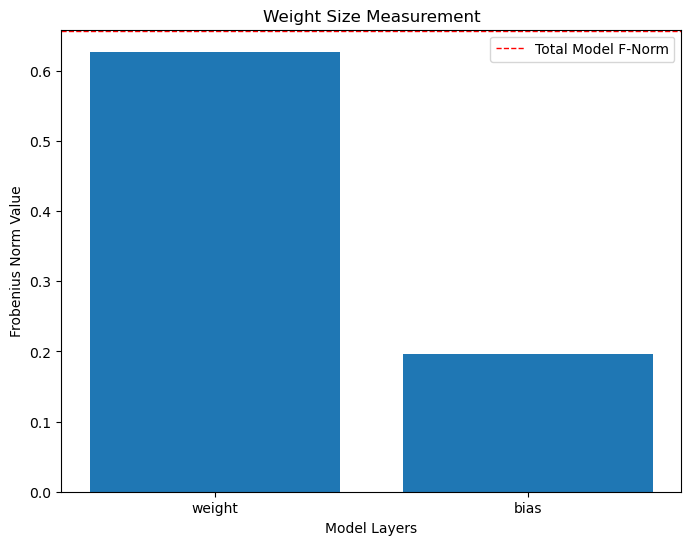

In [13]:
def calculate_frobenius_norm(model):
  """
  Calculate Frobenius Norm per Layer

  Args:
    model: nn.module
      Neural network instance

  Returns:
    norm: float
      Norm value
    labels: list
      Targets
    ws: list
      Weights
  """

  # Initialization of variables
  norm, ws, labels = 0.0, [], []

  # Sum all the parameters
  for name, parameters in model.named_parameters():
    p = torch.sum(parameters**2)
    norm += p

    ws.append((p**0.5).cpu().detach().numpy())
    labels.append(name)

  # Take a square root of the sum of squares of all the parameters
  norm = (norm**0.5).cpu().detach().numpy()

  return norm, ws, labels


set_seed(SEED)
net = nn.Linear(10,1)
norm, ws, labels = calculate_frobenius_norm(net)
print(f'Frobenius norm of Single Linear Layer: {norm:.4f}')
# Plots the weights
plot_weights(norm, labels, ws)

Random seed 2021 has been set.
Frobenius norm of Models weights: 7.3810


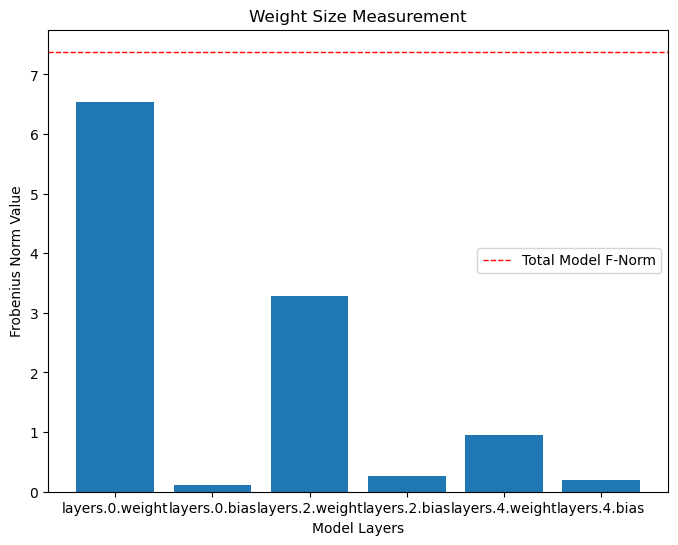

In [16]:
set_seed(seed=SEED)

# Creates a new model
model = AnimalNet()

# Calculates the forbenius norm per layer
norm, ws, labels = calculate_frobenius_norm(model)
print(f'Frobenius norm of Models weights: {norm:.4f}')

# Plots the weights
plot_weights(norm, labels, ws)

### Visualizing Overfitting

Random seed 2021 has been set.


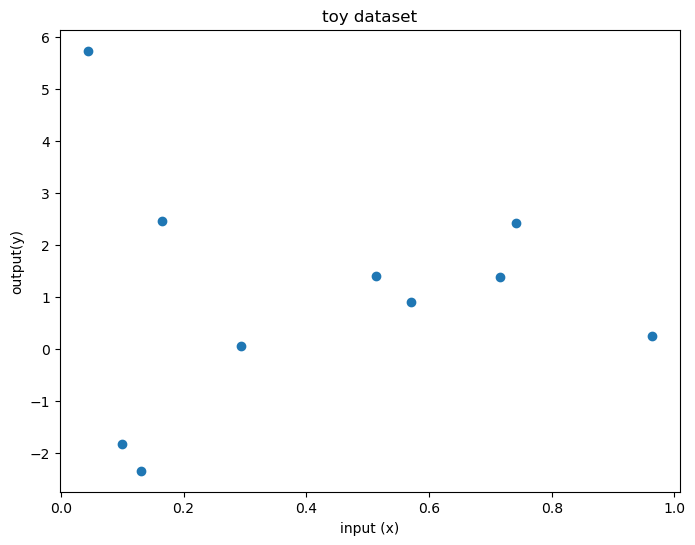

In [17]:
set_seed(seed=SEED)

# Creating train data
# Input
X = torch.rand((10, 1))
# Output
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # Adding small error in the data

# Visualizing train data
plt.figure(figsize=(8, 6))
plt.scatter(X.numpy(),Y.numpy())
plt.xlabel('input (x)')
plt.ylabel('output(y)')
plt.title('toy dataset')
plt.show()

# Creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))

In [34]:
class Net(nn.Module):
    """
    Basic single hidden layer network to visualize overfitting
    """

    def __init__(self):
        super(Net, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1,300),
            nn.ReLU(),
            nn.Linear(300, 500),
            nn.ReLU(),
            nn.Linear(500,1)
        )

    def forward(self, x):
        #x = x.view(x.shape[0], -1)
        return self.layers(x)

In [27]:
class Net(nn.Module):
  """
  Network Class - 2D with following structure
  nn.Linear(1, 300) + leaky_relu(self.fc1(x)) # First fully connected layer
  nn.Linear(300, 500) + leaky_relu(self.fc2(x)) # Second fully connected layer
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self):
    """
    Initialize parameters of Net

    Args:
      None

    Returns:
      Nothing
    """
    super(Net, self).__init__()

    self.fc1 = nn.Linear(1, 300)
    self.fc2 = nn.Linear(300, 500)
    self.fc3 = nn.Linear(500, 1)

  def forward(self, x):
    """
    Forward pass of Net

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output/Predictions
    """
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    output = self.fc3(x)
    return output

In [35]:
model = Net()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

normi, wsi, label = calculate_frobenius_norm(model)

In [36]:
set_seed(seed=SEED)

# Initializing variables
# Losses
train_loss = []
test_loss = []

# Model norm
model_norm = []

# Initializing variables to store weights
norm_per_layer = []

max_epochs = 10000

running_predictions = np.empty((40, int(max_epochs / 500 + 1)))

iters = 0
for epoch in tqdm(range(max_epochs)):
  # Frobenius norm per epoch
  norm, pl, layer_names = calculate_frobenius_norm(model)

  # Training
  model_norm.append(norm)
  norm_per_layer.append(pl)
  model.train()
  optimizer.zero_grad()
  predictions = model(X)
  loss = criterion(predictions, Y)
  loss.backward()
  optimizer.step()

  train_loss.append(loss.data)
  model.eval()
  Y_test = model(X_test)
  loss = criterion(Y_test, 2*X_test)
  test_loss.append(loss.data)

  if (epoch % 500 == 0 or epoch == max_epochs - 1):
    running_predictions[:, iters] = Y_test[:, 0, 0].detach().numpy()
    iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

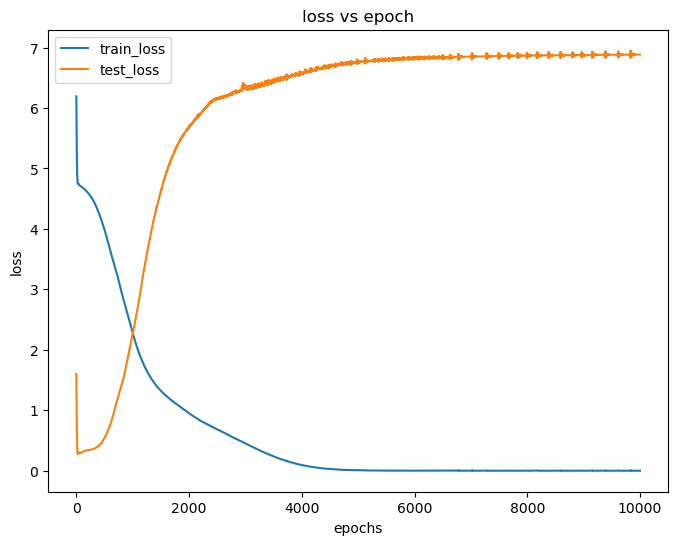

In [38]:
# @title Plot the train and test losses
plt.figure(figsize=(8, 6))
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss vs epoch')
plt.legend()
plt.show()

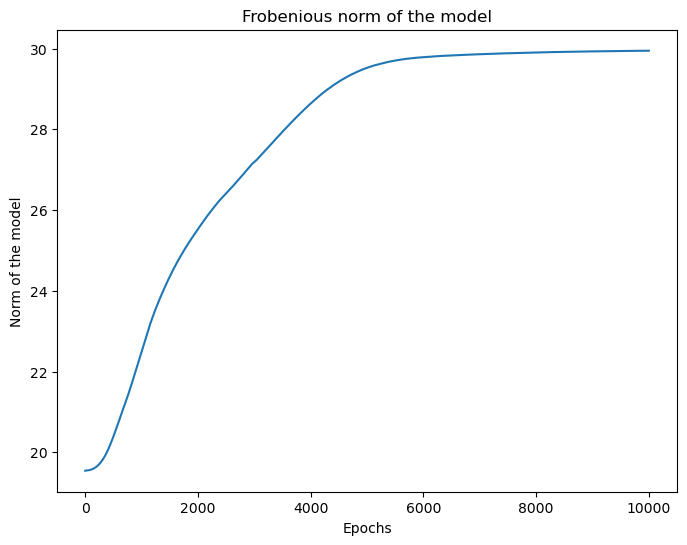

In [39]:
# @markdown Frobenious norm of the model
plt.figure(figsize=(8, 6))
plt.plot(model_norm)
plt.ylabel('Norm of the model')
plt.xlabel('Epochs')
plt.title('Frobenious norm of the model')
plt.show()

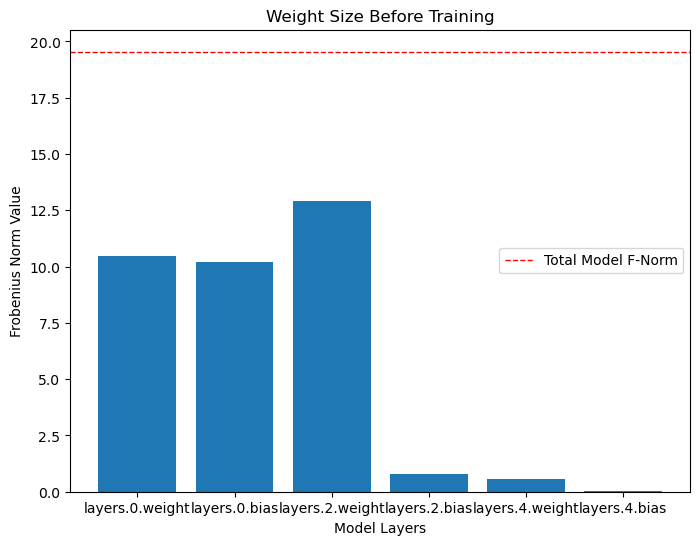

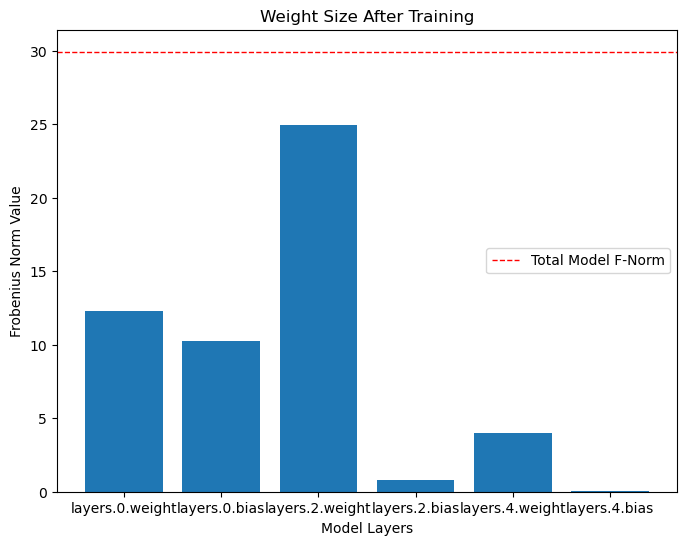

In [40]:
# @markdown Frobenius norm per layer before and after training
normf, wsf, label = calculate_frobenius_norm(model)

plot_weights(float(normi), label, wsi,
             title='Weight Size Before Training')
plot_weights(float(normf), label, wsf,
             title='Weight Size After Training')

#### Conclusion from cells above

The model starts to overfit, which can be seen by weights getting larger and larger (increasing Frobenius norm over epochs) and that the test loss increases while the train loss drops to zero.

### Memorization

In [ ]:
# DataLoaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

# Defining number of examples for train, validation, and test datsets
len_train, len_val, len_test = 100,100,14430

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

data_path = Path('data')/names[-1]/'afhq_10'
img_dataset = ImageFolder(root = data_path/'train', transform=train_transform)

In [ ]:
# DataLoaders for Original Dataset

g_seed = torch.Generator()
g_seed.manual_seed(SEED)

img_train_data, img_val_data, _ = torch.utils.data.random_split(dataset=img_dataset, lengths=[len_train, len_val, len_test])

# Creating train loader and val loader

train_loader = torch.utils.data.DataLoader(dataset=img_dataset,
                                           batch_size=batch_size,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)

val_loader = torch.utils.data.DataLoader(dataset=img_val_data,
                                         batch_size = 1000,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

In [64]:
# Dataloaders for the Random Dataset

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED + 1)

# Splitting randomized data into training and validation data
data_path = pathlib.Path('data')/'afhq_random_32x32/afhq_random' # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
random_img_train_data, random_img_val_data,_ = torch.utils.data.random_split(img_dataset, [len_train, len_val, len_test])

# Randomized train and validation dataloader
rand_train_loader = torch.utils.data.DataLoader(random_img_train_data,
                                                batch_size=batch_size,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g_seed)

rand_val_loader = torch.utils.data.DataLoader(random_img_val_data,
                                              batch_size=1000,
                                              num_workers=2,
                                              worker_init_fn=seed_worker,
                                              generator=g_seed)

In [66]:
# Dataloaders for the Partially Random Dataset

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED + 1)

# Splitting data between training and validation dataset for partially randomized data
data_path = pathlib.Path('data')/'afhq_10_32x32/afhq_10' # Using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
partially_random_train_data, partially_random_val_data,_ = torch.utils.data.random_split(img_dataset, [len_train, len_val, len_test])

# Training and Validation loader for partially randomized data
partial_rand_train_loader = torch.utils.data.DataLoader(partially_random_train_data,
                                                        batch_size=batch_size,
                                                        num_workers=2,
                                                        worker_init_fn=seed_worker,
                                                        generator=g_seed)

partial_rand_val_loader = torch.utils.data.DataLoader(partially_random_val_data,
                                                      batch_size=1000,
                                                      num_workers=2,
                                                      worker_init_fn=seed_worker,
                                                      generator=g_seed)

In [67]:
class BigAnimalNet(nn.Module):
    """
    Bigger Network for Animal Face Classification/Identification
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.layers = nn.Sequential(
            nn.Linear(3*32*32, 124),
            nn.LeakyReLU(),
            nn.Linear(124, 64),
            nn.LeakyReLU(),
            nn.Linear(64,3)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return F.log_softmax(self.layers(x), dim=1)

In [68]:
set_seed(seed=SEED)
normi, wsi, label = calculate_frobenius_norm(BigAnimalNet())

Random seed 2021 has been set.


#### The training in the next cell is too slow on a cpu. See google colab notebook

The point intended to be shown is that the model achieves 100 % training accuracy even on the data where the labels have been shuffled - i.e. random data - which demonstrates that training accuracy isn't a reliable metric and that the model can memorize the training data without learning the underlying pattern of the data (because there is no pattern when it's suffled).

In [69]:
# Here we have 100 true train data.

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}


# Initialize the network
set_seed(seed=SEED)
model = BigAnimalNet()

start_time = time.time()

# Train the network
val_acc_pure, train_acc_pure, _, model = main(args=args,
                                              model=model,
                                              train_loader=train_loader,
                                              val_loader=val_loader)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure, label='Val Accuracy Pure', c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure', c='red', ls='solid')
plt.axhline(y=max(val_acc_pure), c='green', ls='dashed',
            label='max Val accuracy pure')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Early stopping

Stop training before the model overfits.

This also takes too long on cpus. Run it on kaggle or google collab.

In [79]:
def early_stopping_main(args, model, train_loader, val_loader):
  """
  Function to simulate early stopping

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set

  Returns:
    val_acc_list: list
      Val accuracy log until early stop point
    train_acc_list: list
      Training accuracy log until early stop point
    best_model: nn.module
      Model performing best with early stopping
    best_epoch: int
      Epoch at which early stopping occurs
  """

  device = args['device']
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(),
                        lr=args['lr'],
                        momentum=args['momentum'])

  best_acc = 0.0
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 20

  # Keeps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  val_acc_list, train_acc_list = [], []
  for epoch in tqdm(range(args['epochs'])):

    # Train the model
    trained_model = train(args, model=model, train_loader=train_loader, optimizer=optimizer)

    # Calculate training accuracy
    train_acc = test(trained_model, train_loader, criterion=nn.CrossEntropyLoss())

    # Calculate validation accuracy
    val_acc = test(trained_model, val_loader, criterion=nn.CrossEntropyLoss())

    if (val_acc > best_acc):
      best_acc = val_acc
      best_epoch = epoch
      best_model = copy.deepcopy(trained_model)
      wait = 0
    else:
      wait += 1

    if (wait > patience):
      print(f'Early stopped on epoch: {epoch}')
      break

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

  return val_acc_list, train_acc_list, best_model, best_epoch



# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-4,
    'momentum': 0.99,
    'device': DEVICE
}

# Initialize the model
set_seed(seed=SEED)
model = AnimalNet()

## Uncomment to test
val_acc_earlystop, train_acc_earlystop, best_model, best_epoch = early_stopping_main(args, model, train_loader, val_loader)
print(f'Maximum Validation Accuracy is reached at epoch: {best_epoch:2d}')
early_stop_plot(train_acc_earlystop, val_acc_earlystop, best_epoch)

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

TypeError: CrossEntropyLoss.forward() got an unexpected keyword argument 'reduction'

## L1 and L2 Regularization

#### Dataloaders for regularization

In [83]:
data_path = Path('data') / 'afhq_10_32x32' / 'afhq_10'
img_dataset = ImageFolder(root=data_path / 'train', transform = train_transform)

reg_train_data, reg_val_data, _ = torch.utils.data.random_split(dataset=img_dataset, lengths=[len_train, len_val, len_test])

g_seed = torch.Generator()
g_seed.manual_seed(SEED)

reg_train_loader = torch.utils.data.DataLoader(dataset=img_dataset,
                                               batch_size=batch_size,
                                               num_workers=2,
                                               worker_init_fn=seed_worker,
                                               generator=g_seed)

reg_val_loader = torch.utils.data.DataLoader(dataset=img_dataset,
                                             batch_size=batch_size,
                                             num_workers=2,
                                             worker_init_fn=seed_worker,
                                             generator=g_seed)

Train without regularization.

In [148]:

# redifining the train, test, and main functions to take the regularization into account

def train(args, model, train_loader, optimizer, epoch,
          reg_function1=None, reg_function2=None, criterion=nn.CrossEntropyLoss()):
  """
  Trains the current input model using the data
  from Train_loader and Updates parameters for a single pass

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Input dataset
    optimizer: function
      Optimizer
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    model: nn.module
      Neural network instance post training
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    # L1 regularization
    if reg_function2 is None and reg_function1 is not None:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model)
    # L2 regularization
    elif reg_function1 is None and reg_function2 is not None:
      loss = criterion(output, target) + args['lambda2']*reg_function2(model)
    # No regularization
    elif reg_function1 is None and reg_function2 is None:
      loss = criterion(output, target)
    # Both L1 and L2 regularizations
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, loader='Test', criterion=F.nll_loss,
         device='cpu'):
  """
  Tests the current model

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    test_loader: torch.loader
      Test dataset
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    test_loss: float
      Test loss
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  return 100. * correct / len(test_loader.dataset)

def main(args, model, train_loader, val_loader, test_data,
         reg_function1=None, reg_function2=None, criterion=nn.CrossEntropyLoss()):
  """
  Trains the model with train_loader and
  tests the learned model using val_loader

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]

  Returns:
    val_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    param_norm_list: list
      Log of frobenius norm
    trained_model: nn.module
      Trained model/model post training
  """
  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args=args, model=model, train_loader=train_loader, optimizer=optimizer, epoch=epoch,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, loader='Train', device=device)
    val_acc = test(trained_model, val_loader, loader='Val', device=device)
    param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, param_norm_list, model

# Creating test dataset
test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

'''NB: this code is from the collab notebook. Note that they use "val" as the name of the folder in the data but here they call it "test" data. They keep mixing up the terms.'''
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

In [ ]:
args = {
    'epochs' : 150,
    'lr' : 5e-3,
    'momentum' : 0.99,
    'device' : DEVICE,
}

# initialize the model
set_seed(SEED)
model = AnimalNet()

val_acc_unreg, train_acc_unreg, param_norm_unreg, _ = main(args, model=model, train_loader=train_loader, val_loader = val_loader)

# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_unreg, label='Val Accuracy', c='red', ls='dashed')
plt.plot(train_acc_unreg, label='Train Accuracy', c='red', ls='solid')
plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
plt.title('Unregularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(f"Maximum Validation Accuracy reached: {max(val_acc_unreg)}")

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [95]:
def l1_reg(model):
  """
  This function calculates the l1 norm of the all the tensors in the model

  Args:
    model: nn.module
      Neural network instance

  Returns:
    l1: float
      L1 norm of the all the tensors in the model
  """
  l1 = 0.0
  for param in model.parameters():
    # param in one loop corresponds to all weights (and biases if there are any? or no?) of each layer
    print(len(param))
    l1 += torch.sum(torch.abs(param))

  return l1


set_seed(seed=SEED)
## uncomment to test
net = nn.Linear(20, 20, bias=True)
print(net)
print(f"L1 norm of the model: {l1_reg(net)}")

Random seed 2021 has been set.
Linear(in_features=20, out_features=20, bias=True)
20
20
L1 norm of the model: 48.445133209228516


Add L1 regularization to the training

In [99]:
# Set the arguments
args1 = {
    'test_batch_size': 1000,
    'epochs': 150,
    'lr': 5e-3,
    'momentum': 0.99,
    'device': DEVICE,
    'lambda1': 0.001  # <<<<<<<< Tune the hyperparameter lambda1
}

# Initialize the model
set_seed(seed=SEED)
model = AnimalNet()

# Train the model
val_acc_l1reg, train_acc_l1reg, param_norm_l1reg, _ = main(args1,
                                                           model,
                                                           reg_train_loader,
                                                           reg_val_loader,
                                                           test_data=img_test_dataset,
                                                           reg_function1=l1_reg)

# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_l1reg, label='Val Accuracy L1 Regularized',
         c='red', ls='dashed')
plt.plot(train_acc_l1reg, label='Train Accuracy L1 regularized',
         c='red', ls='solid')
plt.axhline(y=max(val_acc_l1reg), c='green', ls='dashed')
plt.title('L1 regularized model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(f"Maximum Validation Accuracy Reached: {max(val_acc_l1reg)}")

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

TypeError: train() got multiple values for argument 'reg_function1'

In [141]:
def l2_reg(model):
  """
  This function calculates the l2 norm of the all the tensors in the model

  Args:
    model: nn.module
      Neural network instance

  Returns:
    l2: float
      L2 norm of the all the tensors in the model
  """

  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(param**2)

  return l2


set_seed(SEED)
## uncomment to test
net = nn.Linear(20, 20)
print(f"L2 norm of the model: {l2_reg(net)}")

Random seed 2021 has been set.
L2 norm of the model: 7.328375339508057


#### Dropout

In [142]:
class NetDropout(nn.Module):

    def __init__(self, *args, **kwargs):
        """
        Initialize parameters of NetDropout

        Args:
        None

        Returns:
        Nothing
        """
        super().__init__(*args, **kwargs)

        self.layers = nn.Sequential(
            nn.Linear(1,300),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(300,500),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(500,1),
        )


    def forward(self, x):
        """
        Forward pass of NetDropout

        Args:
        x: torch.tensor
            Input features

        Returns:
        output: torch.tensor
            Output/Predictions
        """
        output = self.layers(x)
        return output

#### Run to train the network

In [143]:
def calculate_frobenius_norm(model):
    """
    Function to calculate frobenius norm

    Args:
      model: nn.module
        Neural network instance

    Returns:
      norm: float
        Frobenius norm
    """
    norm = 0.0
    # Sum the square of all parameters
    for name,param in model.named_parameters():
        norm += torch.norm(param).data**2
    # Return a square root of the sum of squares of all the parameters
    return norm**0.5

In [125]:
set_seed(seed=SEED)

# Creating train data
X = torch.rand((10, 1))
X.sort(dim = 0)
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # adding small error in the data

X = X.unsqueeze_(1)
Y = Y.unsqueeze_(1)

# Creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))
Y_test_true = 2*X_test


model = NetDropout()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
max_epochs = 1000
iters = 0

running_predictions_dp = np.empty((40, (int)(max_epochs/500+1)))

train_loss_dp, test_loss_dp, model_norm_dp = [], [], []

for epoch in tqdm(range(max_epochs)):
    model_norm_dp.append(calculate_frobenius_norm(model))

    model.train()
    # 1) zero out gradients
    optimizer.zero_grad()

    # 2) forward pass (make prediction)
    Y_train_pred = model(X)

    # 3) calculate loss
    loss = criterion(Y_train_pred, Y)

    # 4) backprop
    loss.backward()

    # 5) update model parameters
    optimizer.step()

    train_loss_dp.append(loss.data)

    model.eval()

    Y_test_pred = model(X_test)

    test_loss_dp.append(criterion(Y_test_pred, Y_test_true).data)

    if (epoch % 500 == 0) or (epoch == max_epochs - 1):
        running_predictions_dp[:, iters] = Y_test_pred[:, 0, 0].detach().numpy()
        iters += 1

Random seed 2021 has been set.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [126]:
set_seed(seed=SEED)

# Creating train data
X = torch.rand((10, 1))
X.sort(dim = 0)
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # adding small error in the data

X = X.unsqueeze_(1)
Y = Y.unsqueeze_(1)

# Creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))
Y_test_true = 2*X_test


model = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
max_epochs = 1000
iters = 0

running_predictions = np.empty((40, (int)(max_epochs/500+1)))

train_loss, test_loss, model_norm = [], [], []

for epoch in tqdm(range(max_epochs)):
    model_norm.append(calculate_frobenius_norm(model))

    model.train()
    # 1) zero out gradients
    optimizer.zero_grad()

    # 2) forward pass (make prediction)
    Y_train_pred = model(X)

    # 3) calculate loss
    loss = criterion(Y_train_pred, Y)

    # 4) backprop
    loss.backward()

    # 5) update model parameters
    optimizer.step()

    train_loss.append(loss.data)

    model.eval()

    Y_test_pred = model(X_test)

    test_loss.append(criterion(Y_test_pred, Y_test_true).data)

    if (epoch % 500 == 0) or (epoch == max_epochs - 1):
        running_predictions[:, iters] = Y_test_pred[:, 0, 0].detach().numpy()
        iters += 1

Random seed 2021 has been set.


  0%|          | 0/1000 [00:00<?, ?it/s]

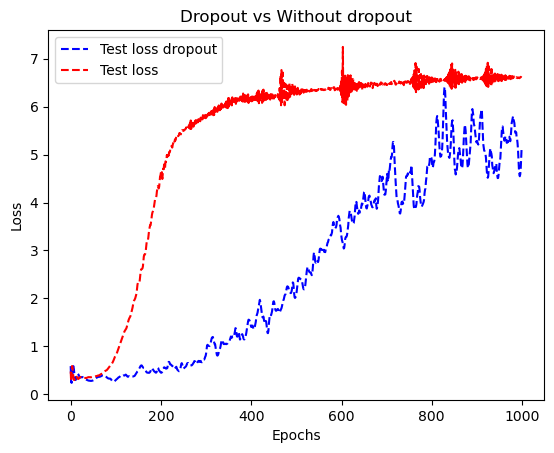

In [127]:
# @markdown Plot the train and test losses with epoch

plt.figure()
plt.plot(test_loss_dp, label='Test loss dropout', c='blue', ls='dashed')
plt.plot(test_loss, label='Test loss', c='red', ls='dashed')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Dropout vs Without dropout')
plt.legend()
plt.show()

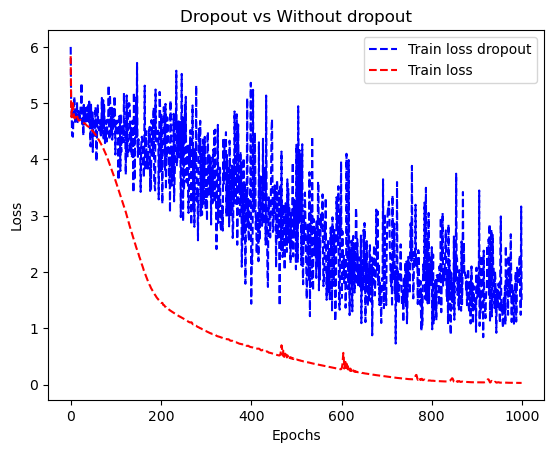

In [128]:
plt.figure()
plt.plot(train_loss_dp, label='Train loss dropout', c='blue', ls='dashed')
plt.plot(train_loss, label='Train loss', c='red', ls='dashed')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Dropout vs Without dropout')
plt.legend()
plt.show()

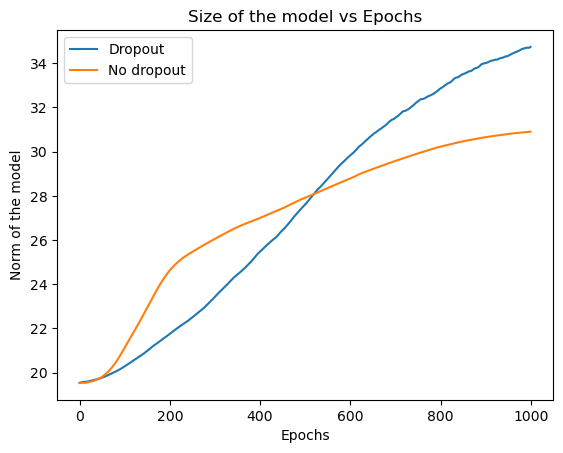

In [129]:
# @markdown Plot model weights with epoch
plt.figure()
plt.plot(model_norm_dp, label='Dropout')
plt.plot(model_norm, label='No dropout')
plt.ylabel('Norm of the model')
plt.xlabel('Epochs')
plt.legend()
plt.title('Size of the model vs Epochs')
plt.show()

#### Notes

- Dropout can help make the network more robust and avoid overfitting in learning.
    - Brittle connections that have just learned noise are broken when a proportion of the neurons are removed.
- Dropout also helps against overfitting by introducing noise in training.
- In final model, all connections/neurons are put in again and the weights need to be scaled by the factor of connections that were dropped in each iteration.
- 
- However, it can hurt model performance when it's not overfitting because it reduces the model's capacity
- Placement matters. Dropout should not be done immediately before last layer because the network has no chance to compensate.
- Dropout can also hurt performance at the beginning of training, so model should be run until convergence.

### Data Augmentation

In [144]:
# DataLoaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

# Defining number of examples for train, validation, and test datsets
len_train, len_val, len_test = 100,100,14430

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

data_path = Path('data')/names[-1]/'afhq_10'
img_dataset = ImageFolder(root = data_path/'train', transform=train_transform)

In [145]:
new_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

data_path = Path('data')/names[-1]/'afhq_10'
img_dataset = ImageFolder(data_path/'train', transform=new_transforms)
# Splitting dataset
new_train_data, _,_ = torch.utils.data.random_split(img_dataset,
                                                    [250, 100, 14280])

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Creating train_loader and Val_loader
new_train_loader = torch.utils.data.DataLoader(new_train_data,
                                               batch_size=batch_size,
                                               worker_init_fn=seed_worker,
                                               generator=g_seed)

In [149]:
args = {
    'epochs' : 250,
    'lr' : 1e-3,
    'momentum' : 0.99,
    'device' : DEVICE,
}

# initialize model
set_seed(SEED)
model_aug = AnimalNet()

# Train the model
val_acc_dataaug, train_acc_dataaug, param_norm_dataaug, _ = main(args=args,
                                                                 model=model_aug,
                                                                 train_loader=new_train_loader,
                                                                 val_loader=val_loader,
                                                                 test_data=img_test_dataset,
                                                                 reg_function1=None,
                                                                 reg_function2=None,
                                                                 )
# Initialize the model
set_seed(seed=SEED)
model_pure = AnimalNet()

val_acc_pure, train_acc_pure, param_norm_pure, _, = main(args,
                                                         model_pure,
                                                         train_loader,
                                                         val_loader,
                                                         img_test_dataset)


# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_pure, label='Val Accuracy Pure',
         c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure',
         c='red', ls='solid')
plt.plot(val_acc_dataaug, label='Val Accuracy data augment',
         c='blue', ls='dashed')
plt.plot(train_acc_dataaug, label='Train Accuracy data augment',
         c='blue', ls='solid')
plt.axhline(y=max(val_acc_pure), c='red', ls='dashed')
plt.axhline(y=max(val_acc_dataaug), c='blue', ls='dashed')
plt.title('Data Augmentation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Random seed 2021 has been set.


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Stochastic gradient descent

- Deep Learning is doing a form of regularization even without regularization functions or dropout.
- Stochastic gradient descent, hyperparameter tuning (adaptable learning rates etc.) are all doing regularization of some sort.
- People usually combine different methods for regularization.

### Learning Rates

- Small learning rates tend to reach deeper minima, but may be overfitting.
- Big learning rates tend to skip local minima and reach flatter minima and to generalize better.

In [151]:
# @markdown #### Generating Data Loaders

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 128
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

data_path = Path('data')/names[-1]/'afhq_10'
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
img_train_data, img_val_data, = torch.utils.data.random_split(img_dataset, [11700,2930])

full_train_loader = torch.utils.data.DataLoader(img_train_data,
                                                batch_size=batch_size,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g_seed)
full_val_loader = torch.utils.data.DataLoader(img_val_data,
                                              batch_size=1000,
                                              num_workers=2,
                                              worker_init_fn=seed_worker,
                                              generator=g_seed)

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)
# With dataloaders: img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,shuffle=False, num_workers=1)
classes = ('cat', 'dog', 'wild')

In [152]:
args = {
    'test_batch_size' : 1000,
    'batch_size' : 32,
    'epochs' : 100,
    'momentum' : 0.9,
    'device' : DEVICE,
}

learning_rates = [5e-4, 1e-3, 5e-3]
acc_dict = {}

for i, learning_rate in enumerate(learning_rates):
    set_seed(SEED)
    model = AnimalNet()
    
    args['lr'] = learning_rate

    val_acc, train_acc, param_norm, _ = main(args=args, 
                                             model=model, 
                                             train_loader=train_loader, 
                                             val_loader=val_loader,
                                             test_data=img_test_dataset)
    
    acc_dict[f'val_{i}'] = val_acc
    acc_dict[f'train_{i}'] = train_acc
    acc_dict[f'param_norm_{i}'] = param_norm

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Hyperparameter tuning

- **Grid Search**: Try all possible combinations of hyperparameters
  - Computationally expensive
- **Random Search**: Randomly try different combinations of hyperparameters
- **Coordinate-wise Gradient Descent**: Change one hyperparameter at a time and keep others constant until optimum performance is reached.
- **Bayesian Optimization/Auto ML**: Your prior is a parameter combination that has worked well for the model on a similar problem in the past, and then you do a local exploration (e.g. gradient descent) from there.

The last two are used the most.